In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from sklearn.decomposition import PCA

In [62]:
pd.read_csv('Truck-Crash-Data/origPositions.csv')

,NodeNumber,xPos,yPos,zPos
0,2023483,4092.1599,323.10001,487.19998
1,2023484,4079.5200,324.01999,493.63998
2,2023485,4066.8899,324.95999,500.07999
3,2023486,4054.2600,325.89999,506.51999
4,2023487,4041.6299,326.85999,512.95996
...,...,...,...,...
3228,2028447,3497.6399,-402.69998,399.26999
3229,2028448,3491.9600,-427.53998,396.35999
3230,2028449,3502.1399,-423.73999,400.56000
3231,2028450,3474.6899,-407.62000,391.42999


We can ignore the node numbers, they're always in order

In [63]:
origPositions = np.array(pd.read_csv('Truck-Crash-Data/origPositions.csv'))[:,1:]
nPoints = origPositions.shape[0]
nDisp = 126
displacementSim = np.zeros((nDisp, nPoints, 3))
for i in range(nDisp):
    displacementSim[i] = np.array(pd.read_csv('Truck-Crash-Data/DisplacementSimulation' + str(i+1) + '.csv'))[:,1:]
displacementSim.shape

(126, 3233, 3)

Visualize the beams before and after the simulated crash:

In [64]:
# rescale for easier plotting 
originalMax = np.max(origPositions, axis = 0)
originalMin = np.min(origPositions, axis = 0)
displacedMax = np.max(displacementSim + origPositions, axis = (0, 1))
displacedMin = np.min(displacementSim + origPositions, axis = (0, 1))
maximum = np.maximum(originalMax, displacedMax)
minimum = np.minimum(originalMin, displacedMin)

origPositionsNorm = (origPositions - minimum)/(maximum - minimum)
displacedPositionsNorm = ((displacementSim + origPositions) - minimum)/(maximum - minimum) 

In [65]:

def beamPlot(nodes, elevation = 30, rotation = 60, which = "both", title = ""):
    """ nodes:      array containing the x, y, z positions of the nodes
        elevation:  elevation angle in the vertical plane in degrees
        rotation:   angle in the horizontal plane in degrees
        which:      one of {"left", "right", "both"}, controls which beams are shown
        title:      string for figure title
    """
    maxLimits = [1, 1, 1]
    minLimits = [0, 0, 0]
    margin = 0.05
    fig = plt.figure(figsize=[8, 8])
    ax = fig.add_subplot(projection = "3d")
    if which == "both":
        ax.scatter(nodes[1714:,0], nodes[1714:, 1], nodes[1714:, 2], s = 5,color = "#488f31", alpha = 0.5) 
        ax.scatter(nodes[:1714,0], nodes[:1714, 1], nodes[:1714, 2], s = 5,color = "#de425b", alpha = 0.5) # we have more nodes in the red beam
    elif which == "right" :
        ax.scatter(nodes[:1714,0], nodes[:1714, 1], nodes[:1714, 2], s = 5, color = "#de425b", alpha = 0.5) 
    elif which == "left":
        ax.scatter(nodes[1714:,0], nodes[1714:, 1], nodes[1714:, 2], s = 5,color = "#488f31", alpha = 0.5)
    ax.tick_params(color = "grey")
    ax.view_init(elev = elevation,azim = rotation)
    ax.set_xlim(min(minLimits[0], 0) - margin, max(maxLimits[0], 1) + margin)
    ax.set_ylim(min(minLimits[1], 0) - margin, max(maxLimits[1], 1) + margin)
    ax.set_zlim(min(minLimits[2], 0) - margin, max(maxLimits[2], 1) + margin)
    plt.title(title, size = 20, y = 0.95, loc="left")
    plt.show()


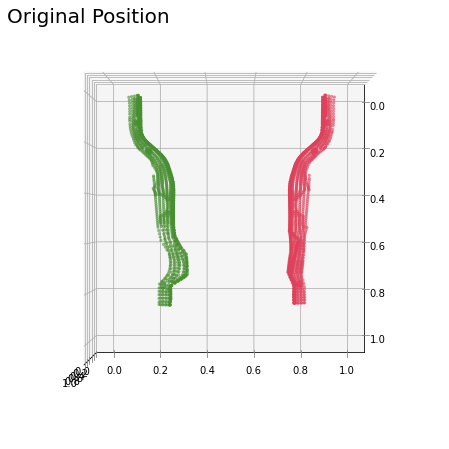

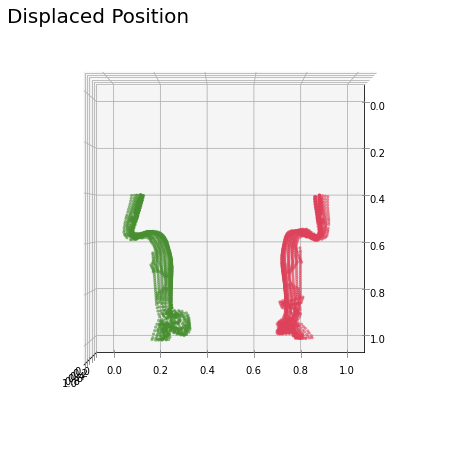

In [66]:
beamPlot(origPositionsNorm[:,:], 90, 0, "both", title = "Original Position")
beamPlot(displacedPositionsNorm[30,:,:], 90, 0, "both", title ="Displaced Position")

Next we want to visualize the displacement:

This is done by first normalizing appropriately and then mapping the displacement in a certain direction to a range of colors. 
We then create a sort of barcode by plotting a thin strip of color for each node. The order of the nodes is fixed so the resulting image gives an idea of the overall displacement. The goal is to have a more abstract but also more accurate way of visualizing a data point.

In [67]:
def normalize_sign(matrix):
    max = np.max(matrix, axis = (0, 1))
    min = np.min(matrix, axis = (0, 1))
    limits = np.maximum(np.abs(max), np.abs(min)) 

    return displacementSim/limits # sign is preserved, normalize with respect to the largest displacement in any direction
displacementNorm = normalize_sign(displacementSim)

In [68]:
def displacementPlot(data, showDirection = "one", title = ""):
    """ data:           normalized displacement data, if direction != "one", then of shape (N, 3), else of shape (N, )
        showDirection:  string, controls which directions are shown
        title:          string for figure title
    """
    norm = mcolors.CenteredNorm(vcenter = 0, halfrange = 1) # assume normalization
    mapper = cm.ScalarMappable(norm = norm, cmap = cm.RdYlBu)
    directions = ["X", "Y", "Z"]

    if showDirection == "xyz":
        fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize=(21,3))
        for i in [0, 1, 2]:
            rgbaArray = np.expand_dims(mapper.to_rgba(data[:, i]), axis = 0)
            ax[i].axis("off")
            ax[i].set_title(directions[i] + "-direction")
            ax[i].imshow(rgbaArray, extent=[0, rgbaArray.shape[1], 0, 1], aspect= "auto")
            fig.tight_layout()
            fig.suptitle(title, size = 20, y = 1)
        plt.show()

    if showDirection == "yz":
        fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(21,3))
        for i in [0, 1]:
            rgbaArray = np.expand_dims(mapper.to_rgba(data[:, i+1]), axis = 0)
            ax[i].axis("off")
            ax[i].set_title(directions[i+1] + "-direction")
            ax[i].imshow(rgbaArray, extent=[0, rgbaArray.shape[1], 0, 1], aspect= "auto")
            fig.tight_layout()
            fig.suptitle(title, size = 20, y = 1)
        plt.show()
            
    if showDirection == "one":
        fig = plt.figure(figsize=(8, 2))
        rgbaArray = np.expand_dims(mapper.to_rgba(data), axis = 0)
        plt.axis("off")
        plt.imshow(rgbaArray, extent=[0, rgbaArray.shape[1], 0, 1], aspect= "auto")
        plt.title(title, size = 20, y = 1, loc = "left")
        plt.show()
    

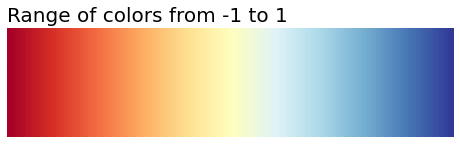

In [69]:
test = np.arange(start = -1, stop = 1, step = 0.01)
displacementPlot(test, title = "Range of colors from -1 to 1")

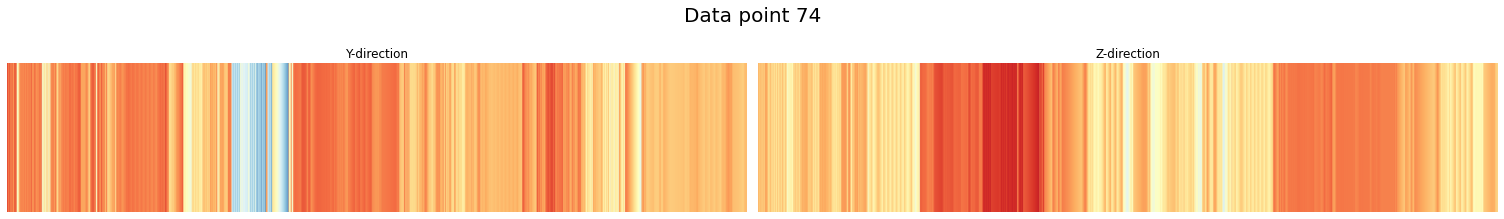

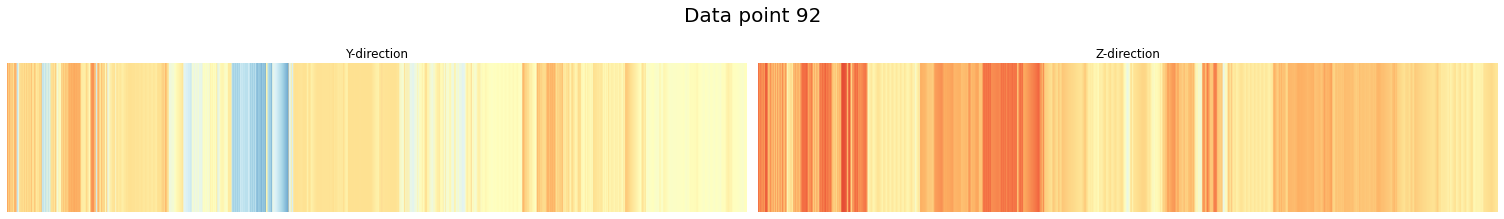

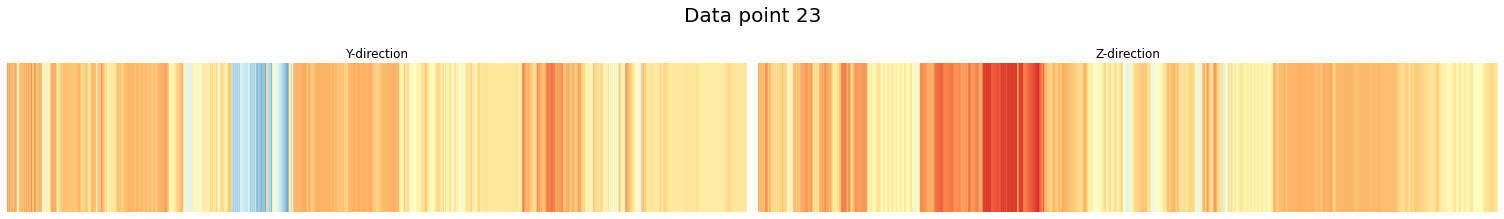

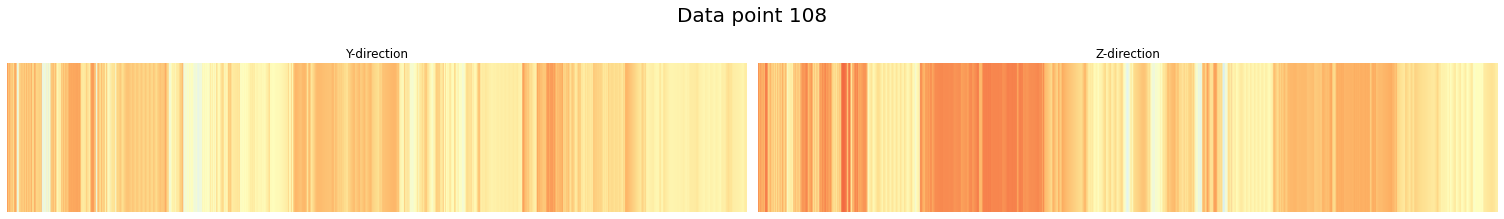

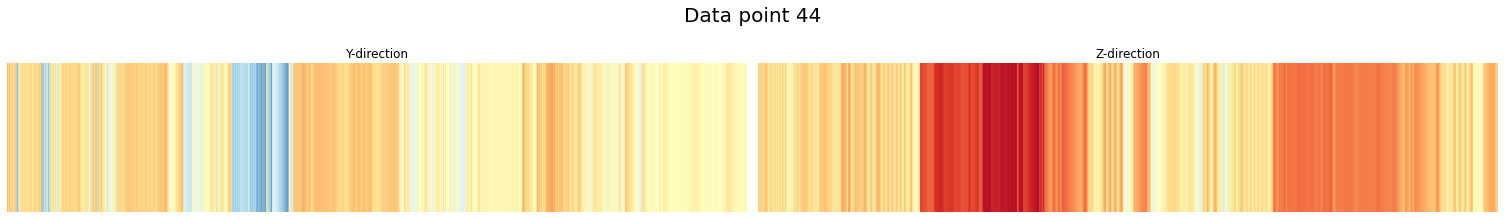

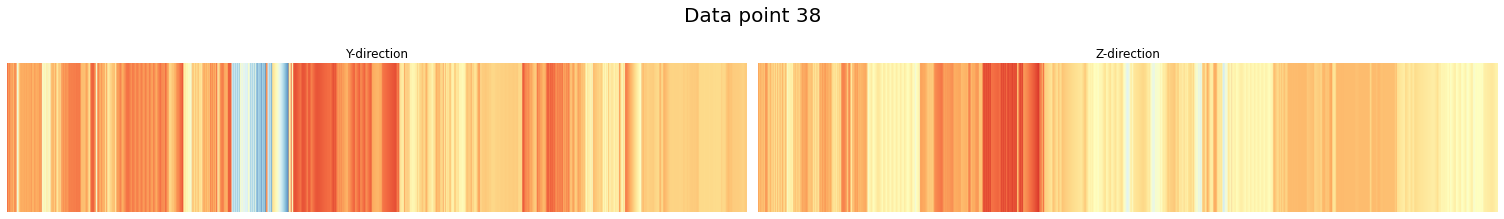

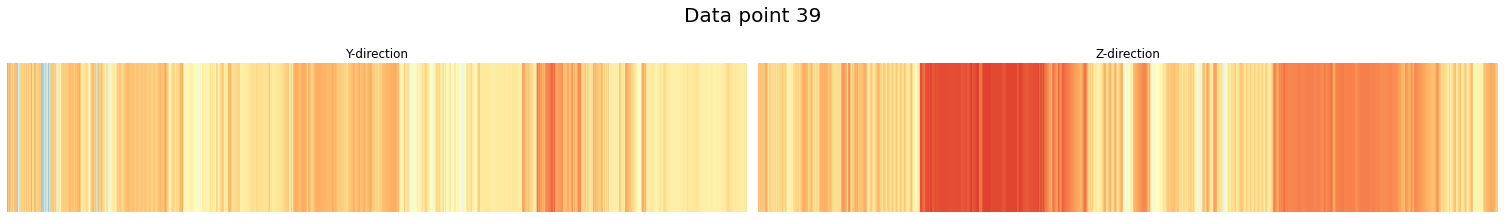

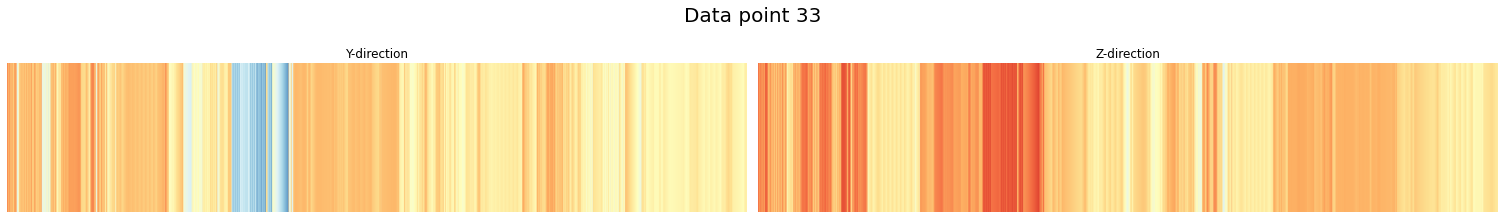

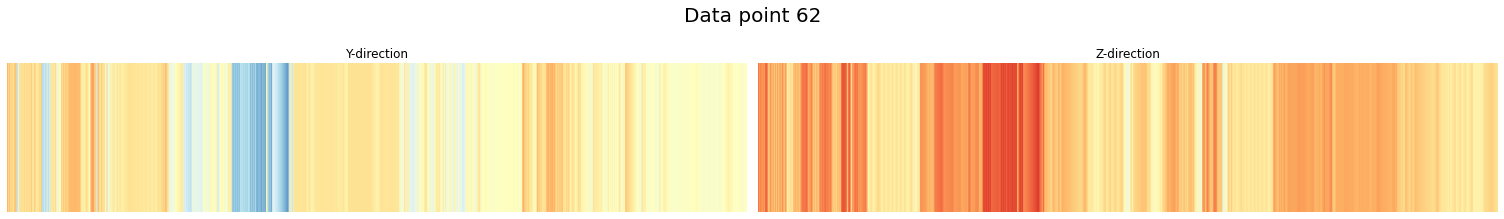

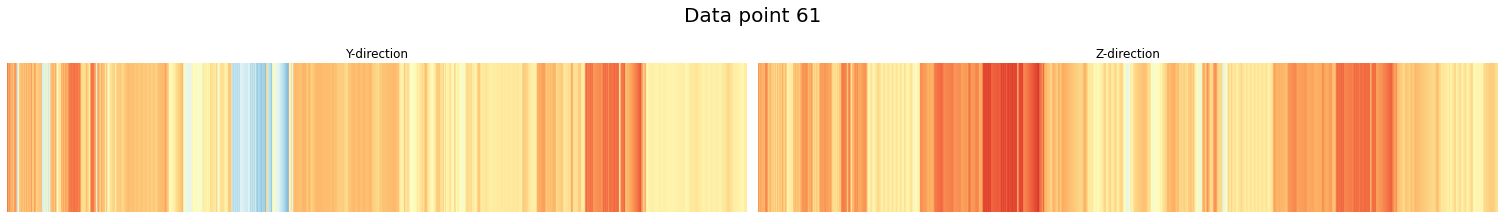

In [70]:
%matplotlib inline
for i in np.random.choice(nDisp, 10):
    displacementPlot(displacementNorm[i, :, :], showDirection= "yz", title = "Data point " + str(i))

### Naive PCA Approaches

First approach: do PCA taking all displacements as separate points. This allows us to use the plot above to look at the eigendisplacements.

In [71]:
dispVector = displacementNorm.reshape((nDisp, nPoints*3))
pca = PCA(n_components=50)
pca = pca.fit(dispVector)
Vq = pca.components_.reshape((50, nPoints, 3))

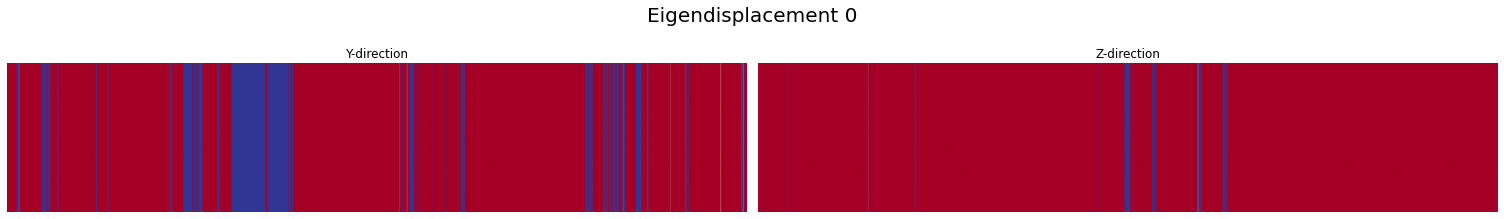

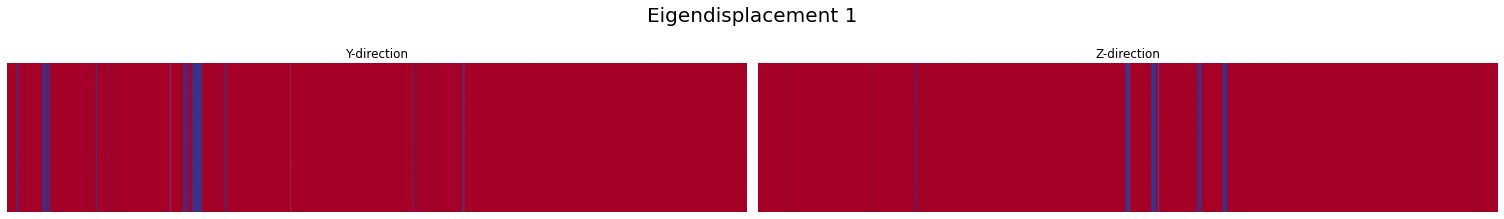

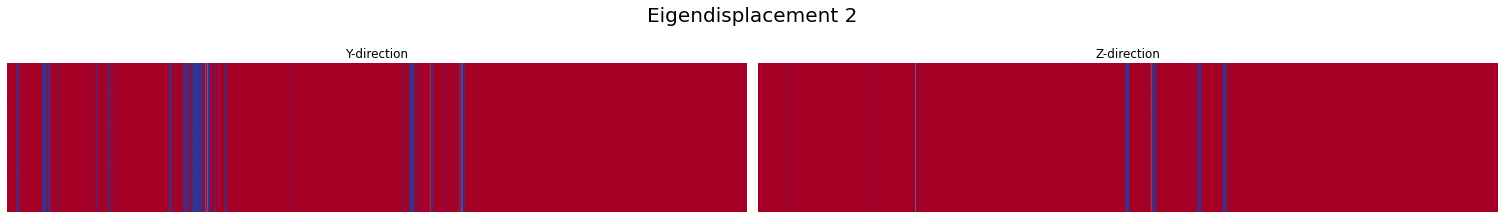

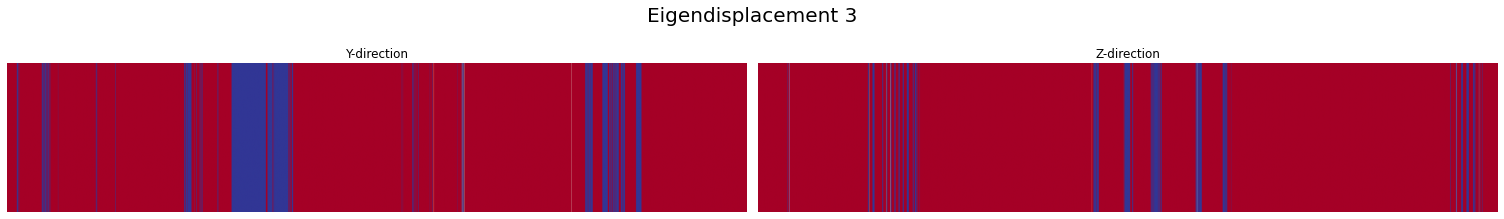

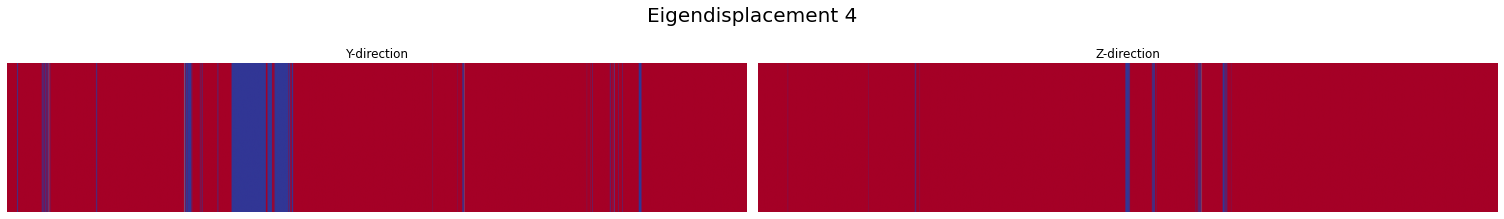

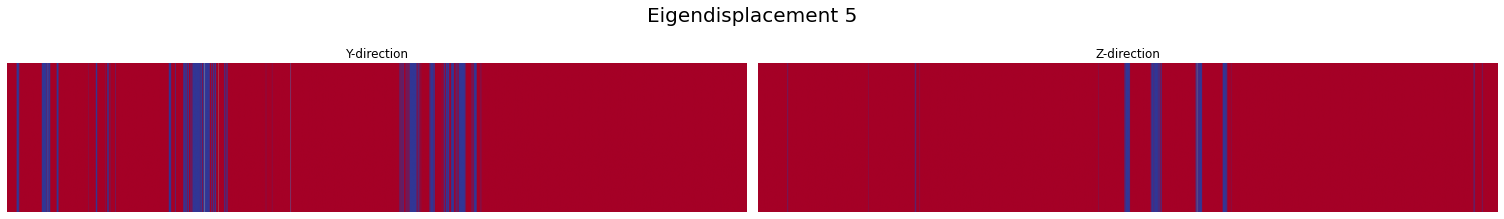

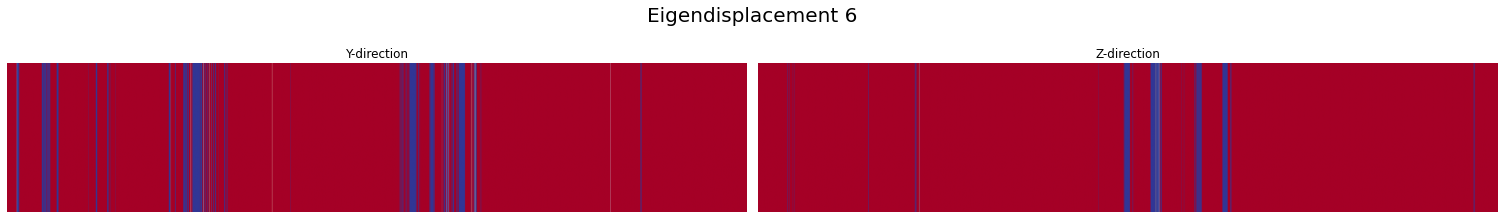

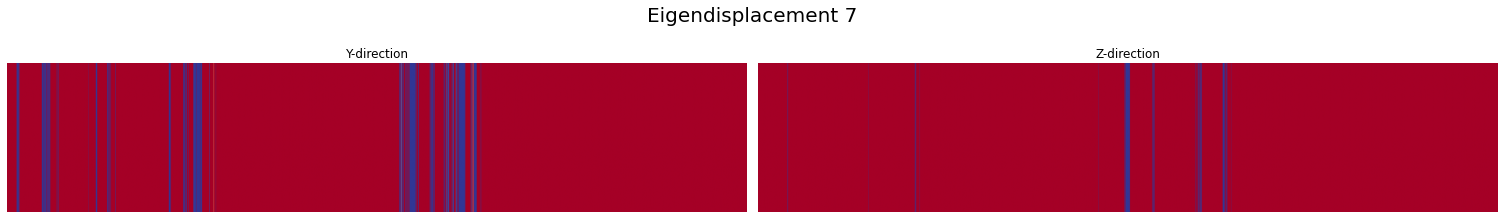

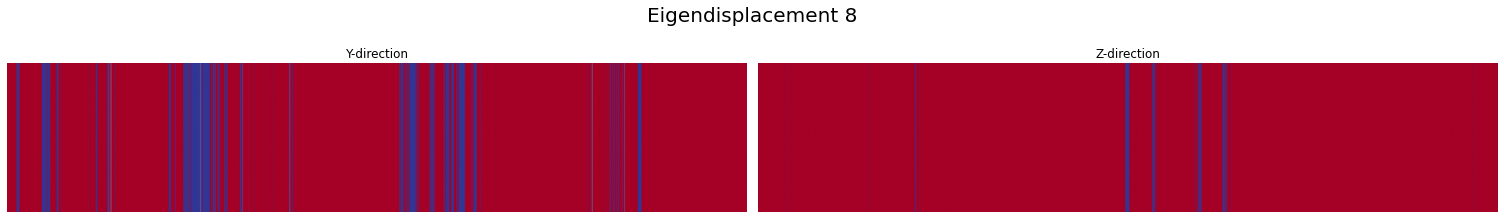

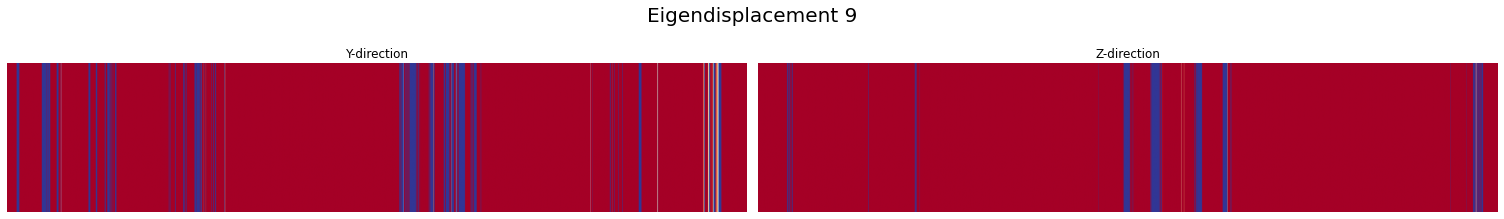

In [72]:
%matplotlib inline
VqNorm = normalize_sign(Vq)
for i in range(10):
    displacementPlot(VqNorm[i, :, :], showDirection= "yz", title = "Eigendisplacement " + str(i))

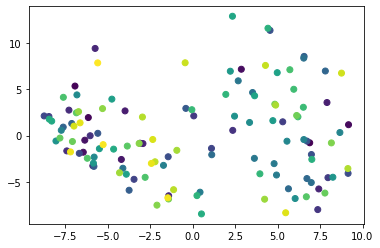

In [73]:
pca = PCA(n_components=2)
pca = pca.fit(dispVector)

reducedDisp = pca.transform(dispVector)
plt.scatter(reducedDisp[:,0],reducedDisp[:,1], c=range(nDisp))

**Second approach** Very similar but classifying points, not simulations.

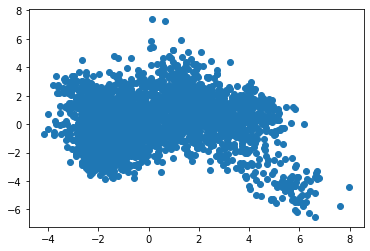

In [74]:
dispVector = displacementNorm.reshape((nPoints, nDisp*3))
pca = PCA(n_components=2)
pca = pca.fit(dispVector)

reducedDisp = pca.transform(dispVector)
plt.scatter(reducedDisp[:,0],reducedDisp[:,1])

This doesn't show any clear differences between the points.

We can also add the displacement to the position to observe the final position, and do these approaches on that data

In [75]:
posVector = displacedPositionsNorm.reshape((nDisp, nPoints*3))
pca = PCA(n_components=2)
pca = pca.fit(posVector)
Vq = pca.components_.reshape((2, nPoints, 3))

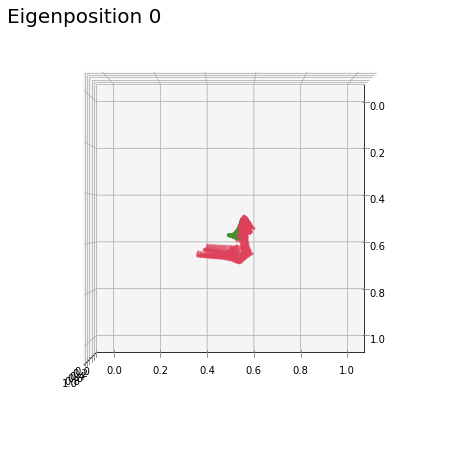

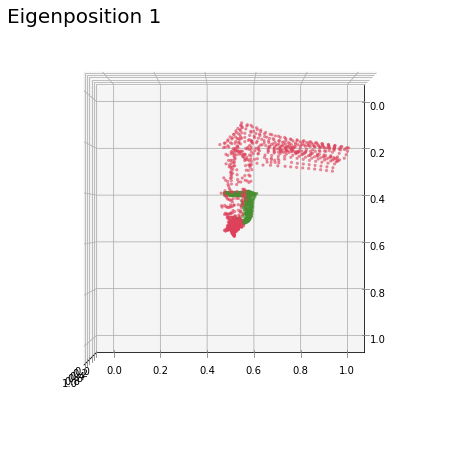

In [76]:
%matplotlib inline
VqNorm = (Vq - np.min(Vq))/np.ptp(Vq)
for i in range(2):
    beamPlot(VqNorm[i,:,:], 90, 0, "both", title ="Eigenposition " + str(i))

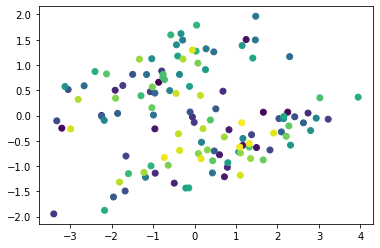

In [77]:
reducedPos = pca.transform(posVector)
plt.scatter(reducedPos[:,0],reducedPos[:,1], c=range(nDisp))

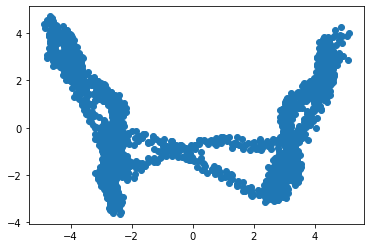

In [78]:
posVector = displacedPositionsNorm.reshape((nPoints, nDisp*3))
pca = PCA(n_components=2)
pca = pca.fit(posVector)

reducedPos = pca.transform(posVector)
plt.scatter(reducedPos[:,0],reducedPos[:,1])

Here you can see it sort of conserves the figure of the displaced beams.